# Prediction test
Feed the model with incomplete sentences adn print the most likely tokens at the end of the sentence.
Evaluate if the model is predicting tokens that fit the language modelling

In [1]:
import os
import sys
import random
import torch
import warnings
from tokenizers import Tokenizer

from pathlib import Path
from torch.utils.data import DataLoader
from IPython.display import SVG, display

### 0. Add packages to python path

In [2]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

In [3]:
b_paths = [os.path.abspath(os.path.join('..', '..', '..')), os.path.abspath(os.path.join('..', '..')), os.path.abspath(os.path.join('..', '..', 'scripts'))]
for b_path in b_paths:
    if b_path not in sys.path:
        sys.path.append(b_path)

BASE_DIR = Path(os.getcwd()).parent.parent.parent.resolve()
%cd $BASE_DIR

I:\My Drive\master_thesis_experiments\glyph-recognition-experiments


## 1. Load model and test set

In [4]:
from models.scripts.generate_dataset import WordDatasetGenerator
from models.scripts.transformer.printable_models import ExplainableTransformer
from models.scripts.transformer.PreEncoders import Conv1DTransformer
from models.scripts.transformer.utils import preprocess_dataset, seed_all, strokes_to_svg, load_json_hypeparameters, pad_collate_fn
from models.scripts.utils import Levenshtein_Normalized_distance

In [5]:
VERSION = "en-en11"
SEED = 2021
BATCH_SIZE = 256
EXPR_MODE="all"
seed_all(SEED)

In [6]:
TOKENIZER_FILE = os.path.join("word_sources","tokenizer-big_en-normalized.json")
VOCAB = Tokenizer.from_file(TOKENIZER_FILE)

BOS_IDX = VOCAB.token_to_id('<bos>')
EOS_IDX = VOCAB.token_to_id('<eos>')
PAD_IDX = VOCAB.token_to_id('<pad>')

N_TOKENS = VOCAB.get_vocab_size() # len(VOCAB)
print(f"Number of Tokens: {N_TOKENS}\n")
print(sorted(VOCAB.get_vocab()))

Number of Tokens: 2000

['!', '!!', '!!!', '"', '#', '$', '%', '&', "'", "'d", "'ll", "'m", "'re", "'s", "'t", "'ve", '(', ')', '),', ').', '*', '+', ',', ',"', '-', '.', '."', '..', '...', '....', '.....', '........', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '<bos>', '<eos>', '<pad>', '<unk>', '=', '>', '?', '??', '@', 'A', 'B', 'BC', 'C', 'D', 'E', 'ER', 'F', 'G', 'H', 'I', 'IN', 'It', 'J', 'K', 'L', 'M', 'N', 'O', 'OT', 'P', 'Q', 'R', 'S', 'T', 'The', 'U', 'V', 'W', 'We', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'ab', 'able', 'ably', 'abour', 'ac', 'acc', 'ace', 'ach', 'ack', 'act', 'acy', 'ad', 'ade', 'ady', 'af', 'aff', 'ag', 'age', 'ages', 'ague', 'ah', 'ai', 'aid', 'aign', 'ail', 'aim', 'ain', 'ained', 'aining', 'ains', 'air', 'ait', 'aj', 'ajor', 'ak', 'ake', 'aken', 'akes', 'aking', 'al', 'ald', 'ale', 'ales', 'alf', 'alif', 'ality', 'all', 'ally', 'als', 'alth', 'am', 'ama', 'ame', 'ament', 'amer', 'ames', 'amp', 'an', 'anc', 'ance', 'an

In [7]:
words = ['Today the government expressed its ',
         'The problem was solved by ',
         'In this situation, nothing is better than ',
         'It was sold to ',
         'Underestimating the issue can be very ',
         'But there is more ',
         'The aim of this test is to ']

BRUSH_SPLIT=0.15
d_gen = WordDatasetGenerator(vocab = VOCAB,
                             expr_mode=EXPR_MODE,
                             words=words,
                             extended_dataset=False,
                             train_split=0.0,
                             valid_split=0.0,
                             fname="words_stroke_prediction_test")
d_gen.generate()
_, _, test = d_gen.generate_from_cache()

test_set = DataLoader(preprocess_dataset(test, VOCAB,  os.path.join(d_gen.fname, "test.pt"), total_len=d_gen.get_learning_set_length("test")), batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

Generating datasets...


Initializing cache...


Test set progress: 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]


Processed test batch... (Total=7).


Train set progress: 0it [00:00, ?it/s]


Processed train batch... (Total=0).


Valid set progress: 0it [00:00, ?it/s]

Processed valid batch... (Total=0).
Using cached dataset file in cache\words_cache\words_stroke_prediction_test.h5
cache\preprocessed_datasets\words_stroke_prediction_test\test.pt
Using cached processed dataset


In [7]:
hp = load_json_hypeparameters(VERSION)
if "vocab" in hp:
    hp.pop("vocab")
model = ExplainableTransformer(name=VERSION, vocab=VOCAB, **hp)
model.count_parameters()
print(f"Conv trainable parameters: {sum(p.numel() for p in model.preencoder.parameters() if p.requires_grad):,}.")
print(f"Encoder trainable parameters: {sum(p.numel() for p in model.encoder.parameters() if p.requires_grad):,}.")
print(f"Decoder trainable parameters: {sum(p.numel() for p in model.decoder.parameters() if p.requires_grad):,}.")
model.load_best_version()
model.to(model.device)

The model has 1,977,544 trainable parameters.
Conv trainable parameters: 504.
Encoder trainable parameters: 497,920.
Decoder trainable parameters: 1,453,520.


ExplainableTransformer(
  (alpha_scaling): AlphaScaling(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=128, out_features=128, bias=True)
          (fc_k): Linear(in_features=128, out_features=128, bias=True)
          (fc_v): Linear(in_features=128, out_features=128, bias=True)
          (fc_o): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=128, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
 

## 2. Test on a single expression (0 and 1 required)

In [21]:
test_set_iter = iter(test_set)
x_pred, y_pred = next(test_set_iter)

x_pred = x_pred.to(model.device)
y_pred = y_pred.to(model.device)

Index: 1 



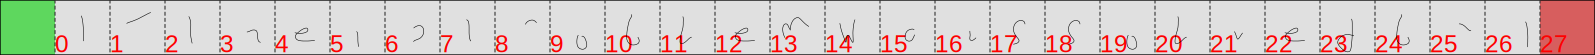

[312, 919, 263, 721, 224, 451, 335, 533, 1837, 739]
[1419, 1076, 390, 1530, 1041, 1815, 240, 1379, 335, 515]
[328, 393, 227, 962, 317, 1979, 90, 310, 818, 15]
[1660, 446, 226, 1037, 573, 280, 391, 342, 183, 1009]
[912, 265, 531, 89, 1121, 1544, 293, 433, 243, 1755]
[395, 273, 1284, 246, 249, 234, 581, 183, 78, 34]
[17, 3, 183, 464, 4, 512, 34, 621, 294, 1767]
[3, 12, 464, 17, 183, 449, 301, 459, 561, 321]
Ground truth =>  [2, 312, 1419, 328, 1660, 912, 395, 183, 3] 

Ground Truth:  The problem was solved by  (len=25)
- Prediction:  The problem was solved by. (len=25)
Normalized Levenshtein distance is: 0.03636363636363636
Alternative Prediction 0:  The problem was solved by. (len=25)
Alternative Prediction 1:  The problem was solved by) (len=25)
Alternative Prediction 2:  The problem was solved by  . (len=27)
Alternative Prediction 3:  The problem was solved by .. (len=27)
Alternative Prediction 4:  The problem was solved by!  (len=26)
Alternative Prediction 5:  The problem was solved 

In [33]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")


svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

eos_tensor = torch.zeros(x_pred[ind].size(-1)) + d_gen.eos_idx

prediction, (cross_att, dec_att, enc_att), token_ids, alternatives = model.predict_with_alternatives(x_pred[ind].unsqueeze(0), num_alternatives=10)
prediction = prediction.replace(" ", '').replace("Ġ", " ")

gt = VOCAB.decode(y_pred[ind].tolist()).replace(" ", '').replace("Ġ", " ")
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len(gt)-2

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {prediction} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(gt, prediction)}")

last_alts = alternatives[-2:]
for i, (al1, al2) in enumerate(zip(last_alts[0], last_alts[1])):
    indexes = token_ids[:-2] + [al1] + [al2]
    alt_prediction = VOCAB.decode(indexes).replace(" ", '').replace("Ġ", " ")
    print(f"Alternative Prediction {i}: {alt_prediction} (len={len(alt_prediction)-2})")

Index: 3 



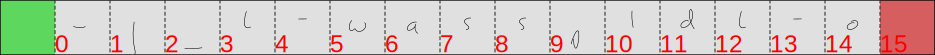

[472, 267, 755, 1307, 263, 571, 994, 1636, 378, 372]
[328, 227, 962, 393, 317, 1979, 275, 310, 86, 445]
[446, 1660, 391, 226, 429, 573, 344, 280, 220, 608]
[283, 256, 267, 1020, 1361, 1099, 271, 79, 822, 183]
[244, 703, 87, 1808, 1490, 1350, 995, 219, 17, 372]
[17, 3, 183, 4, 464, 34, 512, 621, 1291, 1401]
[3, 17, 12, 464, 183, 321, 449, 496, 301, 1291]
Ground truth =>  [2, 472, 328, 446, 283, 244, 183, 3] 

Ground Truth:  It was sold to  (len=14)
- Prediction:  It was sold to. (len=14)
Normalized Levenshtein distance is: 0.06060606060606061
Alternative Prediction 0:  It was sold to. (len=14)
Alternative Prediction 1:  It was solld to. (len=15)
Alternative Prediction 2:  It was suld to. (len=14)
Alternative Prediction 3:  It was sld to. (len=13)
Alternative Prediction 4:  It was saidld to. (len=16)
Alternative Prediction 5:  It wassold to. (len=13)
Alternative Prediction 6:  It was seld to. (len=14)
Alternative Prediction 7:  It was Sld to. (len=13)
Alternative Prediction 8:  It was al

In [40]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")


svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

eos_tensor = torch.zeros(x_pred[ind].size(-1)) + d_gen.eos_idx

prediction, (cross_att, dec_att, enc_att), token_ids, alternatives = model.predict_with_alternatives(x_pred[ind].unsqueeze(0), num_alternatives=10)
prediction = prediction.replace(" ", '').replace("Ġ", " ")

gt = VOCAB.decode(y_pred[ind].tolist()).replace(" ", '').replace("Ġ", " ")
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len(gt)-2

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {prediction} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(gt, prediction)}")

min_ind=2
max_ind=3
last_alts = alternatives[min_ind:max_ind]
last_alts = list(map(list, zip(*last_alts)))

for i, alts in enumerate(last_alts):
    indexes = token_ids
    indexes[min_ind:max_ind] = alts
    alt_prediction = VOCAB.decode(indexes).replace(" ", '').replace("Ġ", " ")
    print(f"Alternative Prediction {i}: {alt_prediction} (len={len(alt_prediction)-2})")

## Measures

In [11]:
words = ['Gold costs 10,000.',
         'Gold weights 10,000.',
         'Gold costs 10,000kg.',
         'Gold weights 10,000.',
         'Gold weights 10,000.',
         'Gold costs kg10,000.']

BRUSH_SPLIT=0.15
d_gen = WordDatasetGenerator(vocab = VOCAB,
                             expr_mode="all",
                             words=words,
                             extended_dataset=False,
                             train_split=0.0,
                             valid_split=0.0,
                             fname="words_stroke_measure_test")
d_gen.generate()
_, _, test = d_gen.generate_from_cache()

test_set = DataLoader(preprocess_dataset(test, VOCAB,  os.path.join(d_gen.fname, "test.pt"), total_len=d_gen.get_learning_set_length("test")), batch_size=BATCH_SIZE, shuffle=False, collate_fn=pad_collate_fn)

Generating datasets...


Initializing cache...


Test set progress: 100%|██████████| 6/6 [00:57<00:00,  9.51s/it]


Processed test batch... (Total=6).


Train set progress: 0it [00:00, ?it/s]


Processed train batch... (Total=0).


Valid set progress: 0it [00:00, ?it/s]


Processed valid batch... (Total=0).
Using cached dataset file in cache\words_cache\words_stroke_measure_test.h5
cache\preprocessed_datasets\words_stroke_measure_test\test.pt


100%|██████████| 6/6 [00:00<00:00, 27.52it/s]


In [12]:
test_set_iter = iter(test_set)
x_pred, y_pred = next(test_set_iter)

x_pred = x_pred.to(model.device)
y_pred = y_pred.to(model.device)

Index: 3 



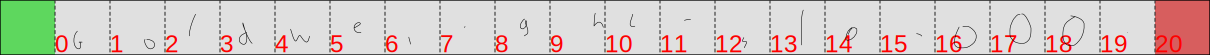

[382, 1616, 408, 234, 304, 861, 308, 542, 1513, 341]
[761, 489, 323, 513, 338, 579, 1099, 82, 1251, 248]
[310, 772, 707, 317, 90, 934, 352, 227, 314, 508]
[399, 764, 295, 256, 183, 702, 15, 329, 76, 274]
[86, 1037, 15, 300, 446, 183, 226, 269, 558, 1480]
[183, 244, 369, 468, 1272, 944, 703, 325, 1496, 267]
[321, 496, 542, 4, 562, 449, 341, 459, 471, 1291]
[301, 542, 464, 561, 471, 449, 341, 462, 496, 183]
[301, 464, 462, 372, 341, 471, 542, 183, 561, 562]
[301, 542, 464, 561, 471, 183, 3, 341, 462, 459]
[464, 301, 3, 542, 183, 561, 1767, 471, 17, 459]
[3, 301, 542, 464, 561, 183, 449, 341, 459, 562]
Ground truth =>  [2, 382, 761, 310, 399, 86, 183, 321, 301, 462, 301, 301, 301, 464, 3] 

Ground Truth:  Gold weights  1 0 , 0 0 0 . (len=26)
- Prediction:  Gold weights  1 0 0 0 . (len=22)
Normalized Levenshtein distance is: 0.14285714285714285
Alternative Prediction 0:  Gold weights  1 0 0 0 . (len=22)
Alternative Prediction 1:  Gold weights  1 0 0 0 0 0 (len=24)
Alternative Prediction 2:

In [18]:
ind = random.choice(range(0, y_pred.shape[0]))
print("Index:", ind, "\n")


svg_str = strokes_to_svg(x_pred[ind], {'height':100, 'width':100}, d_gen.padding_value, BOS_IDX, EOS_IDX)
display(SVG(data = svg_str))

eos_tensor = torch.zeros(x_pred[ind].size(-1)) + d_gen.eos_idx

prediction, (cross_att, dec_att, enc_att), token_ids, alternatives = model.predict_with_alternatives(x_pred[ind].unsqueeze(0), num_alternatives=10)
prediction = prediction.replace(" ", '').replace("Ġ", " ")

gt = VOCAB.decode(y_pred[ind].tolist()).replace(" ", '').replace("Ġ", " ")
gt_list = [i for i in y_pred[ind].tolist() if i != 1]
gt_length = len(gt)-2

print("Ground truth => ", gt_list , '\n')

# Show ground truth and prediction along with the lengths of the words/glyphs
print(f"Ground Truth: {''.join(gt)} (len={gt_length})")
print(f"- Prediction: {prediction} (len={len(prediction)-2})")

print(f"Normalized Levenshtein distance is: {Levenshtein_Normalized_distance(gt, prediction)}")

last_alts = alternatives[-2:]
for i, (al1, al2) in enumerate(zip(last_alts[0], last_alts[1])):
    indexes = token_ids[:-2] + [al1] + [al2]
    alt_prediction = VOCAB.decode(indexes).replace(" ", '').replace("Ġ", " ")
    print(f"Alternative Prediction {i}: {alt_prediction} (len={len(alt_prediction)-2})")